<a href="https://colab.research.google.com/github/kyotoman-koshida/bokete/blob/main/notebooks/20220922.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colabのGPU制限を回避しつつ、うまくLightGBMの特徴量を作る！

- 画像データの特徴量化の方針：CNNモデルの使用
- テキストデータの特徴量化の方針：BERTモデルの使用

### セッティング

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

     |████████████████████████████████| 4.0 MB 6.7 MB/s 
     |████████████████████████████████| 120 kB 66.7 MB/s 
     |████████████████████████████████| 880 kB 62.5 MB/s 
     |████████████████████████████████| 6.6 MB 45.0 MB/s 
     |████████████████████████████████| 1.3 MB 10.3 MB/s 
     |████████████████████████████████| 4.1 MB 7.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import japanize_matplotlib

import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [ ]:
INPUT = "/content/drive/MyDrive/会社/Nishika/bokete" # 所望のディレクトリに変更してください。
train_image_path = "/content/train/"
test_image_path = "/content/test/"

In [ ]:
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

FileNotFoundError: ignored

### データに偏りがないか確認

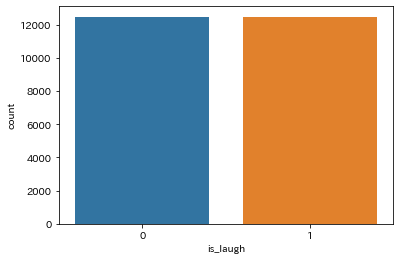

In [ ]:
# 目的変数の分布を確認する
sns.countplot(x="is_laugh", data=train_df)

In [ ]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

In [ ]:
# 画像の重複があるか確認する
print(train_df["odai_photo_file_name"].duplicated().sum())
print(test_df["odai_photo_file_name"].duplicated().sum())

0
0


## 画像データを特徴量化する

画像データを特徴量化するために、DenseNet121を利用する

In [ ]:
import cv2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from tqdm import tqdm, tqdm_notebook
from keras.applications.densenet import preprocess_input, DenseNet121

In [ ]:
class CFG:
    img_size = 224
    batch_size = 17

In [ ]:
def resize_to_square(im):
    old_size = im.shape[:2] 
    ratio = float(CFG.img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # 画像サイズを224×224に変更します
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = CFG.img_size - new_size[1]
    delta_h = CFG.img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im


def load_image(ids, is_train=True):
  if is_train:
    image = cv2.imread(INPUT+train_image_path+ids)
  else:
    image = cv2.imread(INPUT+test_image_path+ids)
  new_image = resize_to_square(image)
  new_image = preprocess_input(new_image)
  return new_image

In [ ]:
inp = Input((224,224,3))
backbone = DenseNet121(input_tensor = inp, include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
image_df_train = train_df[["id", "odai_photo_file_name"]].copy()
image_df_train.head()

,id,odai_photo_file_name
0,ge5kssftl,9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg


In [ ]:
image_ids = image_df_train["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1

# ↓（注意）colabのGPU制限の原因となる危険な部分

基本的にはこのバッチ化の作業はここで行わない。既に実行結果をファイル出力しているので、それを読み込む形でデータの取得を行う。

In [ ]:
features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

  0%|          | 0/1469 [00:00<?, ?it/s]

Error


100%|██████████| 1469/1469 [2:26:47<00:00,  6.00s/it]


In [ ]:
image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("DenseNet121_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

↓なんとか実行できた特徴量化の処理結果をファイル出力してセーブポイントにする

In [ ]:
image_feature.to_csv(os.path.join(INPUT, "image_feature.csv"))

### 画像データのバッチ化ができたので、上記のGPU制限を避けるため、基本的には以下でファイル読み込みによってデータ取得を行う。

In [ ]:
image_feature = pd.read_csv(os.path.join(INPUT, "image_feature.csv"))

In [ ]:
# trainのデータに結合します。
train_df = pd.merge(train_df, image_feature, on="odai_photo_file_name", how="left")

In [ ]:
train_df.shape

(24962, 260)

### ↓（注意）こちらもcolabのGPU制限にかかりうる危険が大きい

In [ ]:
# testデータでも同様なことを行って行きます
image_df_test = test_df[["id", "odai_photo_file_name"]].copy()

image_ids = image_df_test["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1


features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id, is_train=False)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

test_image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("DenseNet121_").reset_index()
test_image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

test_df = pd.merge(test_df, test_image_feature, on="odai_photo_file_name", how="left")

In [ ]:
test_image_feature.to_csv(os.path.join(INPUT, "test_image_feature.csv"))

In [ ]:
test_df.shape

(6000, 259)

### 画像データのバッチ化ができたので、上記のGPU制限を避けるため、基本的には以下でファイル読み込みによってデータ取得を行う。

In [ ]:
test_image_feature = pd.read_csv(os.path.join(INPUT, "test_image_feature.csv"))

# Create Text Features

続いてボケての文章について、BERTモデルを用いて特徴量化していきます。
特徴量化については、以下のディスカッションを参考にさせていただきます。  
[japanese-roberta-baseでテキストデータをembeddingする(小説家になろう ブクマ数予測 \~”伸びる”タイトルとは？\~ より)](https://www.nishika.com/competitions/21/topics/163)


In [ ]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

In [ ]:
class BertSequenceVectorizer:
    def __init__(self, model_name: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = transformers.T5Tokenizer.from_pretrained(self.model_name)
        self.tokenizer.do_lower_case = True 
        self.bert_model = transformers.RobertaModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 256


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy()
        else:
            return seq_out[0][0].detach().numpy()

In [ ]:
BSV = BertSequenceVectorizer('rinna/japanese-roberta-base')

## テキストの欠損値を補間します
train_df["text"] = train_df["text"].fillna('NaN')
test_df["text"] = test_df["text"].fillna('NaN')

## BERT特徴量 
features_text_train = np.stack(train_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)
features_text_test = np.stack(test_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

Downloading:   0%|          | 0.00/787k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/259 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/663 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at rinna/japanese-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at rinna/japanese-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [ ]:
## テキスト特徴量
features_text_train_df = pd.DataFrame(features_text_train).add_prefix("Roberta-text")
features_text_test_df = pd.DataFrame(features_text_test).add_prefix("Roberta-text")

train_df = pd.concat([train_df, features_text_train_df], axis=1)
test_df = pd.concat([test_df, features_text_test_df], axis=1)

In [ ]:
features_text_train_df.to_csv(os.path.join(INPUT, "features_text_train.csv"))
features_text_test_df.to_csv(os.path.join(INPUT, "features_text_test.csv"))

In [ ]:
print(train_df.shape)
print(test_df.shape)

(24962, 1028)
(6000, 1027)


In [ ]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

### データ分割

上の操作はGPU制限をくらい安いので、あらかじめ結果の出力をしておいたファイルを読み込むのが吉

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import japanize_matplotlib

import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
class BertSequenceVectorizer:
    def __init__(self, model_name: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = transformers.T5Tokenizer.from_pretrained(self.model_name)
        self.tokenizer.do_lower_case = True 
        self.bert_model = transformers.RobertaModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 256


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy()
        else:
            return seq_out[0][0].detach().numpy()

In [ ]:
INPUT = "/content/drive/MyDrive/会社/Nishika/bokete" 
train_image_path = "/content/train/"
test_image_path = "/content/test/"
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))

# train_df["img_path"] = train_image_path + train_df["odai_photo_file_name"]
# test_df["img_path"] = test_image_path + test_df["odai_photo_file_name"]

BSV = BertSequenceVectorizer('rinna/japanese-roberta-base')
## テキストの欠損値を補間します
train_df["text"] = train_df["text"].fillna('NaN')
test_df["text"] = test_df["text"].fillna('NaN')

## BERT特徴量 
features_text_train = np.stack(train_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)
features_text_test = np.stack(test_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

image_feature = pd.read_csv(os.path.join(INPUT, "image_feature.csv"), index_col=0)
test_image_feature = pd.read_csv(os.path.join(INPUT, "test_image_feature.csv"), index_col=0)
train_df = pd.merge(train_df, image_feature, on="odai_photo_file_name", how="left")
test_df = pd.merge(test_df, test_image_feature, on="odai_photo_file_name", how="left")

features_text_train_df = pd.read_csv(os.path.join(INPUT, "features_text_train.csv"), index_col=0)
features_text_test_df = pd.read_csv(os.path.join(INPUT, "features_text_test.csv"), index_col=0)
train_df = pd.concat([train_df, features_text_train_df], axis=1)
test_df = pd.concat([test_df, features_text_test_df], axis=1)

# train_df = train_df.drop('img_path', axis=1)
# test_df = test_df.drop('img_path', axis=1)

Some weights of the model checkpoint at rinna/japanese-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at rinna/japanese-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [ ]:
# 学習データと評価データに分割します
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

train_y = train_df["is_laugh"]
train_x = train_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

valid_y = valid_df["is_laugh"]
valid_x = valid_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

test_x = test_df.drop(["id", "odai_photo_file_name", "text"], axis=1)

In [ ]:
print(train_x.shape)
print(valid_x.shape)

(19969, 1024)
(4993, 1024)


### モデル

今回はXGBoostを用いる！

In [ ]:
train_x.columns

Index(['DenseNet121_0', 'DenseNet121_1', 'DenseNet121_2', 'DenseNet121_3',
       'DenseNet121_4', 'DenseNet121_5', 'DenseNet121_6', 'DenseNet121_7',
       'DenseNet121_8', 'DenseNet121_9',
       ...
       'Roberta-text758', 'Roberta-text759', 'Roberta-text760',
       'Roberta-text761', 'Roberta-text762', 'Roberta-text763',
       'Roberta-text764', 'Roberta-text765', 'Roberta-text766',
       'Roberta-text767'],
      dtype='object', length=1024)

In [ ]:
train_x

,DenseNet121_0,DenseNet121_1,DenseNet121_2,DenseNet121_3,DenseNet121_4,DenseNet121_5,DenseNet121_6,DenseNet121_7,DenseNet121_8,DenseNet121_9,...,Roberta-text758,Roberta-text759,Roberta-text760,Roberta-text761,Roberta-text762,Roberta-text763,Roberta-text764,Roberta-text765,Roberta-text766,Roberta-text767
14264,0.004631,0.109193,0.025144,0.020850,0.079606,0.002669,0.008779,0.006266,0.073080,0.031325,...,0.101882,-0.047859,-0.172752,0.220107,-0.249669,0.157174,0.080622,-0.320360,0.254947,-0.174245
11377,0.003204,0.590380,0.023956,0.010063,0.138702,0.002936,0.004462,0.005249,0.076028,0.022851,...,0.023666,-0.077782,-0.040989,0.293941,-0.219843,-0.101320,0.168499,-0.490826,0.178169,0.017657
10900,0.004610,0.136990,0.043493,0.013530,0.037341,0.001711,0.009317,0.010761,0.060229,0.030415,...,0.080365,0.066863,-0.112254,0.126338,0.159985,-0.121778,-0.024609,-0.487827,0.067757,0.163971
5588,0.002661,0.126644,0.095172,0.034829,0.096950,0.002561,0.008409,0.002549,0.123545,0.029752,...,-0.177968,0.249357,-0.209219,0.111095,-0.459266,-0.070921,-0.152035,-0.128940,-0.228855,-0.095328
19719,0.002182,0.214062,0.044908,0.018451,0.135327,0.002643,0.006930,0.005429,0.046946,0.035946,...,0.167795,0.187928,-0.103810,0.547884,-0.044658,-0.078072,-0.065139,0.230522,-0.067110,-0.279579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22080,0.002376,0.089513,0.030323,0.016545,0.186583,0.002330,0.006003,0.004526,0.046662,0.035849,...,-0.218273,-0.028048,-0.223767,0.172559,-0.165486,0.119914,-0.170937,-0.477803,0.249829,-0.288337
4956,0.004016,0.139677,0.019194,0.011447,0.053261,0.001659,0.012763,0.007156,0.126799,0.029756,...,0.248529,0.088770,-0.125469,0.240107,-0.159466,0.185626,-0.071883,-0.070617,-0.206400,-0.149821
11820,0.002534,0.248831,0.032847,0.014414,0.064135,0.002187,0.007710,0.006070,0.139498,0.029733,...,0.180494,0.049313,-0.155194,0.129014,-0.240390,0.235046,0.095212,-0.280797,-0.180062,-0.118635
8535,0.001932,0.044957,0.073890,0.023109,0.074239,0.002292,0.012663,0.005926,0.024933,0.036552,...,0.046925,0.003199,-0.248792,0.405206,-0.267061,-0.270601,-0.252924,0.027823,0.089230,-0.237093


In [ ]:
import xgboost

# evals = [(train_x, 'train'), (train_y, 'eval')]
evals_result = {} 
xgb_clf = xgboost.XGBClassifier(
    #目的関数の指定 初期値も二乗誤差です
                    # 回帰問題
                    objective='binary:logistic',
                    # 学習用の指標 (RMSE)
                    eval_metric='rmse',
                    #学習のラウンド数 early_stoppingを利用するので多めに指定
                    n_estimators=50000,
                    #boosterに何を用いるか 初期値もgbtreeです
                    booster='gbtree',

                    verbose=10,

                    early_stopping_rounds=10, 
                    #学習率
                    learning_rate=0.05,
                    #木の最大深さ
                    max_depth=7,
                    #シード値
                    random_state=0,
                        #正則化
                    reg_alfa=6.8594164113286965e-06,

                    sub_sample=0.16056047423047484,

                    colsample_bytree=0.6987351856651322,

                    min_child_weight=1.1103525577197584,
                    
                    # evals=evals,

                    evals_result=evals_result
)
xgb_clf.fit(train_x, train_y)
# xgb_clf.fit(train_x, train_y, 
#                 eval_set=[(train_x, train_y),(valid_x, valid_y)], 
#             )

In [ ]:
# 特徴量の重要度を可視化。
xgboost.plot_importance(xgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = xgb_clf.predict(valid_x, num_iteration=xgb_clf.best_iteration)
val_pred_max = np.round(xgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

In [ ]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

### 予測する

In [ ]:
test_pred = xgb_clf.predict(test_x, num_iteration=xgb_clf.best_iteration)

In [ ]:
submission_df["is_laugh"] = test_pred
submission_df.head()

In [ ]:
OUTPUT = "/content/drive/MyDrive/会社/Nishika/bokete/results" # ディレクトリを指定してください
submission_df.to_csv(os.path.join(OUTPUT,'20220922koshida-submission.csv'), index=False)

他の試作

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）
